In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))


from log_processing import process_log, from_csv

In [2]:
def calculate_vwaps(data):
    b1 = data["bid_price_1"]
    b1v = data["bid_volume_1"]
    b2 = data["bid_price_2"]
    b2v = data["bid_volume_2"]
    b3 = data["bid_price_3"]
    b3v = data["bid_volume_3"]
    a1 = data["ask_price_1"]
    a1v = data["ask_volume_1"]
    a2 = data["ask_price_2"]
    a2v = data["ask_volume_2"]
    a3 = data["ask_price_3"]
    a3v = data["ask_volume_3"]

    bid_vwap = (b1 * b1v + b2 * b2v + b3 * b3v) / (b1v + b2v + b3v)
    ask_vwap = (a1 * a1v + a2 * a2v + a3 * a3v) / (a1v + a2v + a3v)
    vwap = (bid_vwap + ask_vwap) / 2
    return bid_vwap, ask_vwap, vwap

In [3]:
round = 2

DAY_2 = 2
DAY_1 = 1
DAY_0 = 0
days = [DAY_2, DAY_1, DAY_0]

products = ["CROISSANTS", "JAMS", "DJEMBES", "PICNIC_BASKET1", "PICNIC_BASKET2"]
day_data = {}

for day in days:
    activities, trades = from_csv(round, day, "../../data")
    product_data = {}
    for product in products:
        product_data[product] = activities[activities["product"] == product].reset_index()

        product_data[product]["spread"] = product_data[product]["ask_price_1"] - product_data[product]["bid_price_1"]
        bid_vwap, ask_vwap, vwap = calculate_vwaps(product_data[product])
        product_data[product]["bid_vwap"] = bid_vwap
        product_data[product]["ask_vwap"] = ask_vwap
        product_data[product]["vwap"] = vwap

    day_data[day] = product_data


for day in days:
    synthetic_pb1_mid = 6 * day_data[day]["CROISSANTS"]["mid_price"] + 3 * day_data[day]["JAMS"]["mid_price"] + day_data[day]["DJEMBES"]["mid_price"]
    synthetic_pb1_ask = 6 * day_data[day]["CROISSANTS"]["ask_price_1"] + 3 * day_data[day]["JAMS"]["ask_price_1"] + day_data[day]["DJEMBES"]["ask_price_1"]
    synthetic_pb1_bid = 6 * day_data[day]["CROISSANTS"]["bid_price_1"] + 3 * day_data[day]["JAMS"]["bid_price_1"] + day_data[day]["DJEMBES"]["bid_price_1"]
    synthetic_pb1_vask = 6 * day_data[day]["CROISSANTS"]["ask_vwap"] + 3 * day_data[day]["JAMS"]["ask_vwap"] + day_data[day]["DJEMBES"]["ask_vwap"]
    synthetic_pb1_vbid = 6 * day_data[day]["CROISSANTS"]["bid_vwap"] + 3 * day_data[day]["JAMS"]["bid_vwap"] + day_data[day]["DJEMBES"]["bid_vwap"]
    synthetic_pb1_vwap = 6 * day_data[day]["CROISSANTS"]["vwap"] + 3 * day_data[day]["JAMS"]["vwap"] + day_data[day]["DJEMBES"]["vwap"]
    synthetic_pb1 = pd.DataFrame({
        "timestamp": day_data[day]["CROISSANTS"]["timestamp"],
        "mid_price": synthetic_pb1_mid,
        "ask_price_1": synthetic_pb1_ask,
        "bid_price_1": synthetic_pb1_bid,
        "ask_vwap": synthetic_pb1_vask,
        "bid_vwap": synthetic_pb1_vbid,
        "vwap": synthetic_pb1_vwap
    })
    synthetic_pb2_mid = 4 * day_data[day]["CROISSANTS"]["mid_price"] + 2 * day_data[day]["JAMS"]["mid_price"]
    synthetic_pb2_ask = 4 * day_data[day]["CROISSANTS"]["ask_price_1"] + 2 * day_data[day]["JAMS"]["ask_price_1"]
    synthetic_pb2_bid = 4 * day_data[day]["CROISSANTS"]["bid_price_1"] + 2 * day_data[day]["JAMS"]["bid_price_1"]
    synthetic_pb2_vask = 4 * day_data[day]["CROISSANTS"]["ask_vwap"] + 2 * day_data[day]["JAMS"]["ask_vwap"]
    synthetic_pb2_vbid = 4 * day_data[day]["CROISSANTS"]["bid_vwap"] + 2 * day_data[day]["JAMS"]["bid_vwap"]
    synthetic_pb2_vwap = 4 * day_data[day]["CROISSANTS"]["vwap"] + 2 * day_data[day]["JAMS"]["vwap"]
    synthetic_pb2 = pd.DataFrame({
        "timestamp": day_data[day]["CROISSANTS"]["timestamp"],
        "mid_price": synthetic_pb2_mid,
        "ask_price_1": synthetic_pb2_ask,
        "bid_price_1": synthetic_pb2_bid,
        "ask_vwap": synthetic_pb2_vask,
        "bid_vwap": synthetic_pb2_vbid,
        "vwap": synthetic_pb2_vwap
    })

    day_data[day]["SYN_PICNIC_BASKET1"] = synthetic_pb1
    day_data[day]["SYN_PICNIC_BASKET2"] = synthetic_pb2

In [4]:
combined_data = {}
for day in days:
    for product in day_data[day].keys():
        product_data = day_data[day][product]
        if product not in combined_data.keys():
            combined_data[product] = [product_data]
        else:
            product_data["timestamp"] += combined_data[product][-1]["timestamp"].max() + 100
            combined_data[product].append(product_data)

for product in combined_data.keys():
    combined_data[product] = pd.concat(combined_data[product], ignore_index=True).reset_index()

In [7]:
# Analyze each day separately or combine them
data = day_data[DAY_2]
# data = combined_data
time = data["CROISSANTS"]["timestamp"]

In [8]:
log_file = "../../backtests/test.log"
trader_data, products_data, activities, trades = process_log(log_file)

In [9]:
sb1 = products_data["SYNTHETIC_BASKET1"]

sb1_buy_spread = sb1["buy_spread"]
sb1_sell_spread = sb1["sell_spread"]
sb1_buy_mean = sb1["buy_mean"]
sb1_sell_mean = sb1["sell_mean"]
sb1_zscore_buy = sb1["z_score_buy"]
sb1_zscore_sell = sb1["z_score_sell"]

In [10]:
pb1_bid = data["PICNIC_BASKET1"]["bid_price_1"]
pb1_ask = data["PICNIC_BASKET1"]["ask_price_1"]

cro_bid = data["CROISSANTS"]["bid_price_1"]
cro_ask = data["CROISSANTS"]["ask_price_1"]

jams_bid = data["JAMS"]["bid_price_1"]
jams_ask = data["JAMS"]["ask_price_1"]

dje_bid = data["DJEMBES"]["bid_price_1"]
dje_ask = data["DJEMBES"]["ask_price_1"]

spread_buy = pb1_ask - (6 * cro_bid + 3 * jams_bid + dje_bid)
spread_sell = pb1_bid - (6 * cro_ask + 3 * jams_ask + dje_ask)

z_score_buy = (spread_buy - np.mean(spread_buy)) / np.std(spread_buy)
z_score_sell = (spread_sell - np.mean(spread_sell)) / np.std(spread_sell)


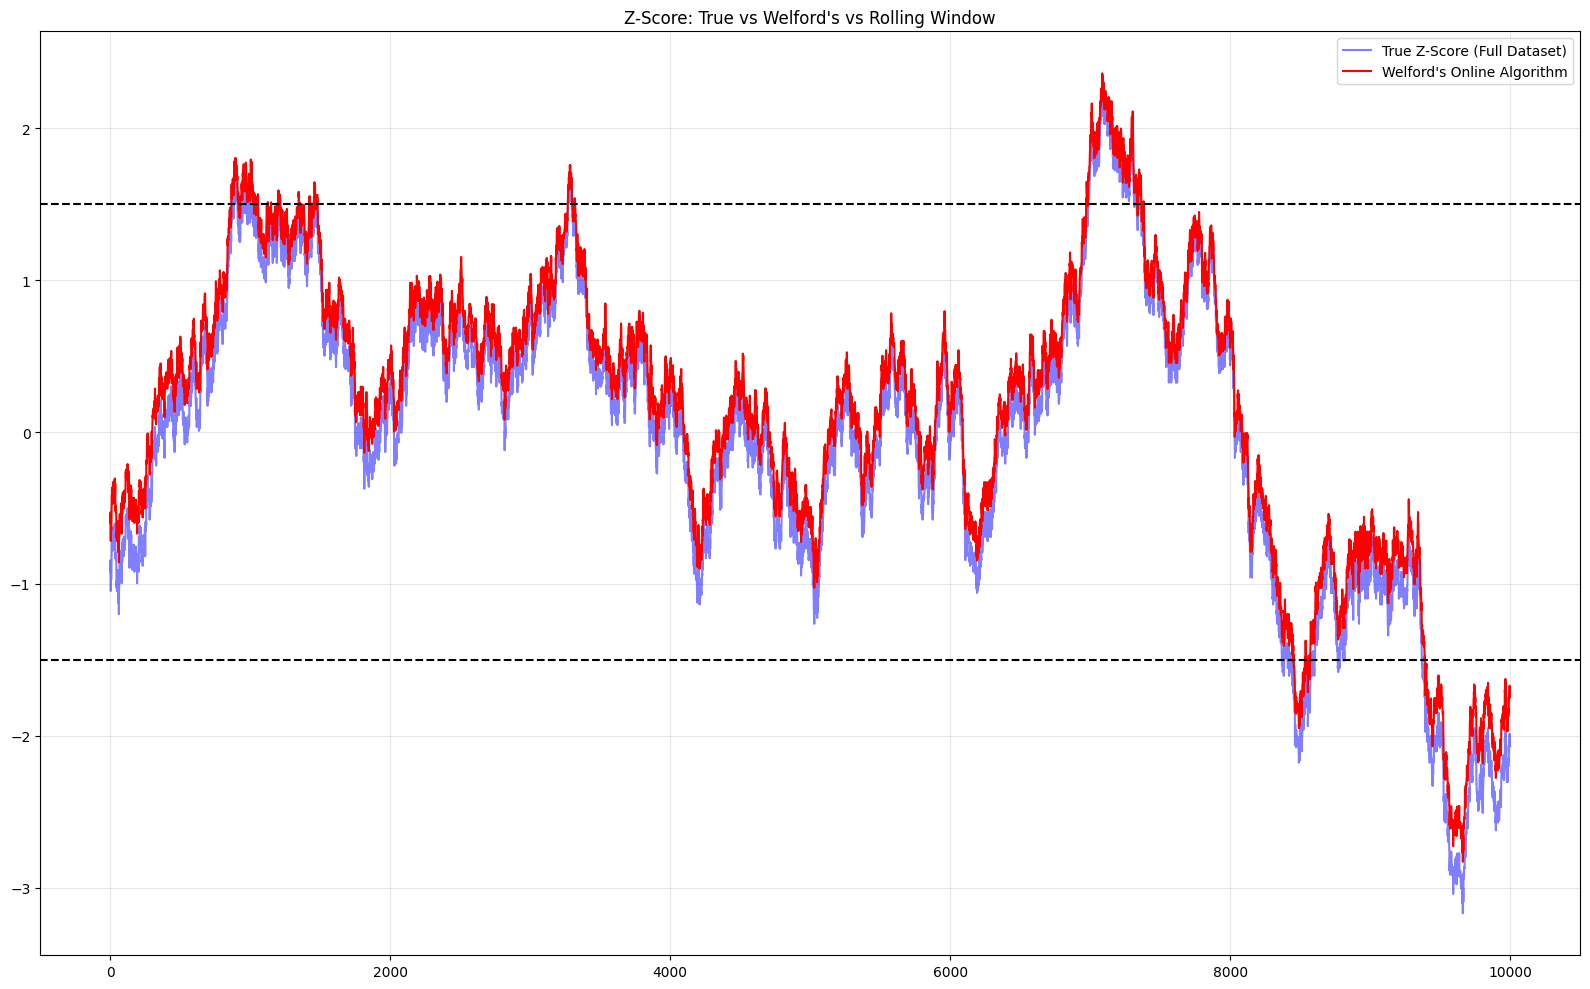

Number of signals (z-score >= 1.5):
True Z-Score: 1283
Welford Z-Score: 1360


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate spreads
spread_buy = pb1_ask - (6 * cro_bid + 3 * jams_bid + dje_bid)

# True Z-Score (using full dataset)
true_mean = np.mean(spread_buy)
true_std = np.std(spread_buy)
true_z_score = (spread_buy - true_mean) / true_std

# 1. Welford's Online Algorithm
class WelfordStatsWithPriors:
    def __init__(self, initial_mean=None, initial_variance=None, initial_count=10):
        self.n = initial_count if initial_mean is not None else 0
        self.mean = initial_mean if initial_mean is not None else 0.0
        self.M2 = initial_variance * initial_count if initial_variance is not None else 0.0
        
    def update(self, x):
        self.n += 1
        delta = x - self.mean
        self.mean += delta / self.n
        delta2 = x - self.mean
        self.M2 += delta * delta2
        
    def get_mean(self):
        return self.mean
    
    def get_std(self):
        return np.sqrt(self.M2 / self.n if self.n > 1 else 1.0)


# Initialize our statistics calculators
N = 30000
BUY_MEAN = 60.08
BUY_VAR = 7246.50

welford_stats = WelfordStatsWithPriors(BUY_MEAN, BUY_VAR, N)


# Calculate z-scores for each method
welford_z_scores = []
ewma_fast_z_scores = []
ewma_slow_z_scores = []
rolling_z_scores = []


# Process the data
for i, spread in enumerate(spread_buy):
    # Update statistics
    welford_stats.update(spread)
    
    # Calculate z-scores
    if welford_stats.n > 10:  # Ensure some minimum data points
        welford_z = (spread - welford_stats.get_mean()) / welford_stats.get_std()
        welford_z_scores.append(welford_z)
    else:
        welford_z_scores.append(np.nan)


# Create dataframe for plotting
df = pd.DataFrame({
    'spread': spread_buy,
    'true_z_score': true_z_score,
    'welford_z_score': welford_z_scores,
})

# Plot the results
fig, axes = plt.subplots(1, 1, figsize=(16, 10))

# Plot 2: True Z-Score vs Welford
axes.plot(df['true_z_score'], label='True Z-Score (Full Dataset)', color='blue', alpha=0.5)
axes.plot(df['welford_z_score'], label="Welford's Online Algorithm", color='red')
axes.axhline(y=1.5, color='black', linestyle='--')
axes.axhline(y=-1.5, color='black', linestyle='--')
axes.set_title("Z-Score: True vs Welford's vs Rolling Window")
axes.legend()
axes.grid(True, alpha=0.3)


plt.tight_layout()
plt.show()

# Print some statistics about signal generation
signals_true = (abs(df['true_z_score']) >= 1.5).sum()
signals_welford = (abs(df['welford_z_score']) >= 1.5).sum()

print(f"Number of signals (z-score >= 1.5):")
print(f"True Z-Score: {signals_true}")
print(f"Welford Z-Score: {signals_welford}")

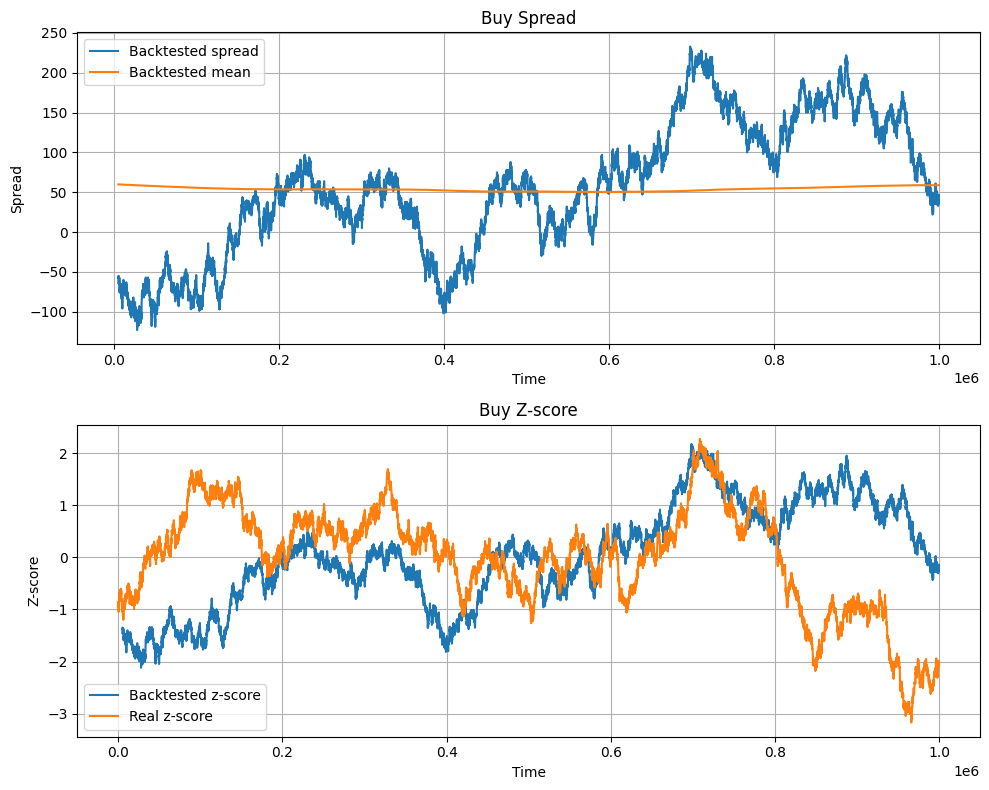

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))


axs[0].plot(time, sb1_buy_spread, label="Backtested spread")
axs[0].plot(time, sb1_buy_mean, label="Backtested mean")
axs[0].grid()
axs[0].set_title("Buy Spread")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Spread")
axs[0].legend()


axs[1].plot(time, sb1_zscore_buy, label="Backtested z-score")
axs[1].plot(time, z_score_buy, label="Real z-score")
axs[1].grid()
axs[1].set_title("Buy Z-score")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Z-score")
axs[1].legend()

plt.tight_layout()